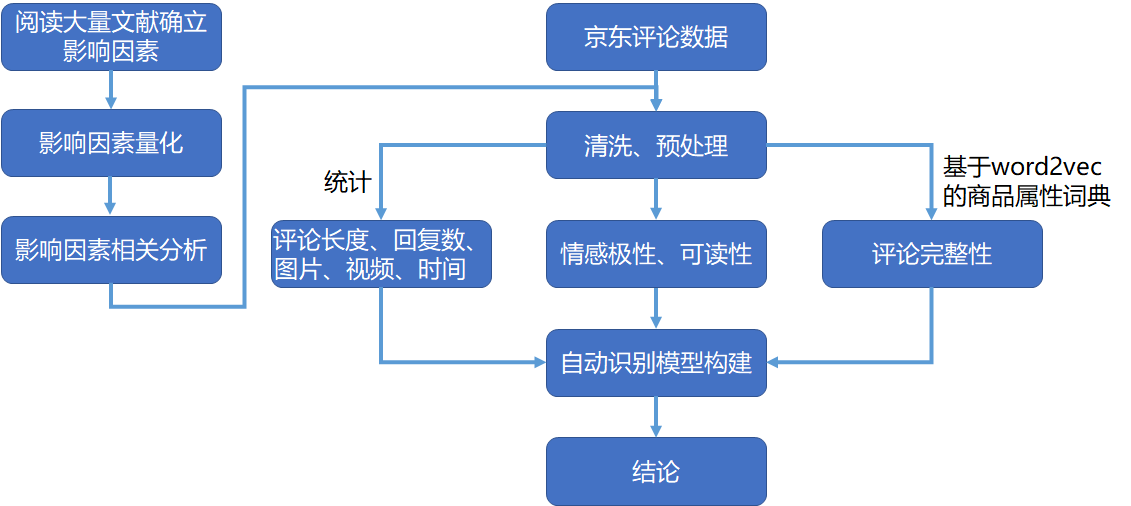

## 数据预处理，特征工程
- python爬虫爬取京东评论数据
- 爬取字段包含：'ID','NICKNAME','CONTENT','CREATIONTIME','SCORE','REPLYCOUNT','IMAGESTATUS','IMAGECOUNT','USEFULVOTECOUNT','plusAvailible'
- 数据清洗
    - 去除重复值；
    - 去除含有缺失数据的数据；
    - 去除系统默认好评，即（'CONTENT=="此用户未填写评价内容"'）；
    - 共17016条评论数据
- 特征工程
    - 评论文本长度（CONTENT_LENGTH）
    - 评论回复数(REPLYCOUNT)
    - 图片数量(IMAGECOUNT)
    - 评论星级(SCORE)
    - 评论者是否是plus会员(WHETHERPLUS)
    - 时间(time_delta)
    - 评论完整性(COMPLETENESS)
    - 评论主观性（subjectivity）

In [1]:
import pymysql
import pandas as pd

db = pymysql.connect(host = 'localhost',user = 'root',password = '123456',db = 'zeddhzm',charset='utf8')   
cur = db.cursor()   
sql = "SELECT * FROM jdcomment_320_cleansed_3_get_dummies"
cur.execute(sql)
result = cur.fetchall()
df = pd.DataFrame(list(result),columns=['ID','CONTENT','CREATIONTIME','USEFULVOTECOUNT','CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity','whether_useful'])
cur.close()
db.close()

In [2]:
dff = df.copy()

In [3]:
dff.shape

(17016, 14)

In [3]:
dff.head(1)

,ID,CONTENT,CREATIONTIME,USEFULVOTECOUNT,CONTENT_LENGTH,REPLYCOUNT,IMAGECOUNT,SCORE,plus,not_plus,time_delta,COMPLETENESS,subjectivity,whether_useful
0,13872879901,机器刚到手，就发布降价信息！服了，气管接口粗糙，屏幕连个膜都没有！写的记忆14次，实际10次...,2020-03-04 18:21:47,51,35,14,2,1,1,0,380,5,0.212,1


In [5]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15556 entries, 0 to 15555
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               15556 non-null  object        
 1   NICKNAME         15556 non-null  object        
 2   CONTENT          15556 non-null  object        
 3   CONTENT_LENGTH   15556 non-null  int64         
 4   CREATIONTIME     15556 non-null  datetime64[ns]
 5   SCORE            15556 non-null  int64         
 6   REPLYCOUNT       15556 non-null  int64         
 7   IMAGESTATUS      15556 non-null  int64         
 8   IMAGECOUNT       15556 non-null  int64         
 9   USEFULVOTECOUNT  15556 non-null  int64         
 10  date             15556 non-null  object        
 11  date_now         15556 non-null  object        
 12  time_delta       15556 non-null  int64         
 13  COMPLETENESS     15556 non-null  int64         
 14  whether_useful   15556 non-null  int64

---
## 自动识别模型构建
- SVM
- Naive Bayes
- Ensemble learning
    - Random Forest(CART)--bagging
    - Adaboost--boosting
    - GBDT(CART)--boosting
    - XGBoost--boosting

### SVM

In [4]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [5]:
all_x = dff[['CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity']]
all_y = dff['whether_useful']

x_train,x_test,y_train,y_test = train_test_split(all_x, all_y, test_size=0.3, random_state=30)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)
y_train = np.array(y_train).ravel()

grid = GridSearchCV(svm.SVC(), param_grid={"C":[0.01, 0.1, 1, 5, 10, 100], "gamma": [100, 10, 1, 0.1, 0.01]}, cv=3)
grid.fit(x_train,y_train)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10, 'gamma': 100} with a score of 0.92965


In [15]:
svm_model = svm.SVC(C=10, kernel='rbf', gamma=100, probability=True, random_state=30)
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print("训练集：",svm_model.score(x_train,y_train))

训练集： 0.9999160439929476


#### 模型评价指标

In [16]:
#Accuracy
#准确率，是最常用的分类性能指标。Accuracy = (TP+TN)/(TP+FN+FP+TN), 即正确预测的正反例数 /总数
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))    #normalize：默认值为True，返回正确分类的比例；如果为False，返回正确分类的样本数

#Precision （查准率）精确率
#只针对预测正确的【正样本】，表现为预测为正的里面有多少真正是正的。可理解为查准率。Precision = TP/(TP+FP)。
from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary'))   # pos_label !

#Recall （查全率）召回率
#召回率表现出在实际【正样本】中，分类器能预测出多少。与真正率相等，可理解为查全率。Recall = TP/(TP+FN)。
from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))   # pos_label !

#PR曲线

#F1 score
#F1 score 又称 F-Measure，是一个综合评价指标。F值是精确率和召回率的调和值，更接近于两个数较小的那个，所以精确率和召回率接近时，F值最大。很多推荐系统的评测指标就是用F值的。2/F1 = 1/Precision + 1/Recall
from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

#AUC (Area Under Curve)
#直接根据真实值（必须是二值）、预测值（可以是0/1,也可以是proba值）计算出auc值，中间过程的roc计算省略。
#AUC（Area Under Curve）被定义为ROC曲线下的面积(ROC的积分)，通常大于0.5小于1。随机挑选一个正样本以及一个负样本，分类器判定正样本的值高于负样本的概率就是 AUC 值。AUC值(面积)越大的分类器，性能越好。
from sklearn.metrics import roc_auc_score        #常用
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))


Accuracy:  0.932615083251714
Precision:  0.9893617021276596
Recall:  0.3522727272727273
F1 score:  0.5195530726256984
roc_auc_score:  0.675917879913401


##### TP, TN, FP, FN 

In [ ]:
dfff = pd.DataFrame({'y_pred':list(y_pred), 'y_true': y_test})

dfff.shape
print('TP: ',len(dfff.query('y_pred == y_true & y_pred == 1')))
print('TN: ', len(dfff.query('y_pred == y_true & y_pred == 0')))
print('FP: ', len(dfff.query('y_pred != y_true & y_pred == 1')))
print('FN: ', len(dfff.query('y_pred != y_true & y_pred == 0')))

precision = 186/(186+2)
print('precision: ', precision)
recall = 186/(186+342)
print('recall: ', recall)
f1 = 2*(precision*recall)/(precision+recall)
print('f1 score: ', f1)

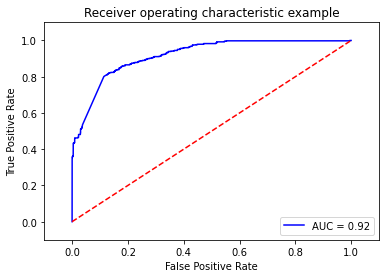

In [20]:
#ROC曲线
#ROC曲线，又称 感受性曲线。X轴：假正率（FPR）（1-TNR）（1-specificity）。Y轴：真正率（TPR）（sensitivity）。ROC曲线离对角线越近，模型的准确率越低
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_predict = svm_model.predict(x_test)
y_probs = svm_model.predict_proba(x_test)               #模型的预测得分(y_scores)。y.predict() / y.predict_proba()区别
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1], pos_label=1, sample_weight=None, drop_intermediate=True) # y_probs[:,1] / y_predict 
roc_auc = auc(fpr, tpr)                                 #auc为Roc曲线下的面积

#开始画ROC曲线
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('False Positive Rate')                       #横坐标是fpr
plt.ylabel('True Positive Rate')                        #纵坐标是tpr
plt.title('Receiver operating characteristic example')
plt.show()

---
@ ChenKaiiiiiiii
你好!

这些指标从各个不同的角度评价了你的分类模型的准确度和性能。你自己找做算法模型，可以选择一种指标评价你的算法即可。但是如果是要和别人的算法做比较，那么就得使用别人算法使用的指标。目前roc曲线，pr曲线是比较主流的比较算法优劣的工具。

这些曲线并不是为了模型采取什么样的阈值，主要还是算法评估。

roc曲线和pr曲线是用于二分类的，但是多分类模型一样可以使用，你需要把它看成若干个二分类问题，分别求出各个阈值对应的指标，然后取平均。

---

In [15]:
y_probs

array([[0.93258458, 0.06741542],
       [0.91914395, 0.08085605],
       [0.92355463, 0.07644537],
       ...,
       [0.92517389, 0.07482611],
       [0.91714019, 0.08285981],
       [0.92373905, 0.07626095]])

In [19]:
y_probs[:,0]

array([0.93258458, 0.91914395, 0.92355463, ..., 0.92517389, 0.91714019,
       0.92373905])

In [22]:
thresholds

array([2.00000000e+00, 1.00000000e+00, 9.89793667e-01, 9.89550680e-01,
       9.52048844e-01, 9.46813117e-01, 8.00810701e-01, 7.93107160e-01,
       7.46980708e-01, 7.38429167e-01, 6.96569577e-01, 6.93107371e-01,
       6.70863204e-01, 5.92753059e-01, 5.20777173e-01, 4.91994176e-01,
       4.53474443e-01, 4.41939729e-01, 4.34785455e-01, 4.32928465e-01,
       4.09264616e-01, 3.94552550e-01, 3.60628988e-01, 3.47475665e-01,
       3.46345623e-01, 3.37801594e-01, 3.21256833e-01, 3.16125845e-01,
       3.04291562e-01, 2.93718002e-01, 2.80784208e-01, 2.80564988e-01,
       2.75923375e-01, 2.73775821e-01, 2.67814237e-01, 2.62391094e-01,
       2.56782581e-01, 2.55350222e-01, 2.54556571e-01, 2.50927987e-01,
       2.36422029e-01, 2.30117857e-01, 2.23741885e-01, 2.19908610e-01,
       2.19754117e-01, 2.16157461e-01, 2.14958008e-01, 2.07693748e-01,
       1.98219285e-01, 1.96995720e-01, 1.91118396e-01, 1.87223483e-01,
       1.86691925e-01, 1.84597776e-01, 1.82459316e-01, 1.80441228e-01,
      

### Naive Bayes

In [33]:
from sklearn import naive_bayes   #假设各特征之间独立（朴素）
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   
    #概率模型（树形模型）不需要归一化，因为它们不关心变量的值，而是关心变量的分布和变量之间的条件概率，如决策树、RF。
    #而像Adaboost、SVM、LR、Knn、KMeans之类的最优化问题就需要归一化。

In [34]:
all_x = dff[['CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity']]
all_y = dff['whether_useful']
x_train,x_test,y_train,y_test = train_test_split(all_x, all_y, train_size=0.7, random_state=30)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [35]:
nb_0 = naive_bayes.GaussianNB()   #假设了数据符合高斯分布。 参数只有一个，即先验概率priors
nb_0.fit(x_train, y_train)
y_pred = nb_0.predict(x_test)

GaussianNB()

In [38]:
from sklearn.metrics import accuracy_score
print ('Accuracy: %.5f' % accuracy_score(y_test, y_pred))

from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary'))

from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import roc_auc_score        
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

Accuracy: 0.89586
Precision:  0.5204081632653061
Recall:  0.20647773279352227
F1 score:  0.2956521739130435
roc_auc_score:  0.5919759859750022


### Ensemble learning

In [35]:
import pandas
pandas.__version__

'1.2.1'

In [34]:
import swifter   #加速pandas.apply()

#### Random Forest

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
all_x = dff[['CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity']]
all_y = dff['whether_useful']
x_train,x_test,y_train,y_test = train_test_split(all_x, all_y, train_size=0.7, random_state=30)

In [5]:
rf_0 = RandomForestClassifier(oob_score=True, random_state=30)
rf_0.fit(x_train, y_train)
y_pred = rf_0.predict(x_test)

##### RF调参(bagging框架参数 + 决策树参数)
- bagging框架参数
    - **n_estimators 最大弱学习器个数**
    - oob_score 即是否采用袋外样本来评估模型的好坏(out of bag) default=False
    - criterion 即CART树做划分时对特征的评价标准（Gini/信息增益 || mse/mae） default=gini
- 决策树参数
    - **max_features RF划分时考虑的最大特征数** default=None, 划分时考虑所有的特征数, 如果是"log2"意味着划分时最多考虑log2N个特征；如果是"sqrt"或者"auto"意味着划分时最多考虑N−−√个特征。一般来说，如果样本特征数不多，比如小于50，我们用默认的"None"就可以了，如果特征数非常多，我们可以灵活使用刚才描述的其他取值来控制划分时考虑的最大特征数，以控制决策树的生成时间。
    - **max_depth 决策树最大深度** default=3
    - **min_samples_split 内部节点再划分所需最小样本数** default=2
    - **min_samples_leaf 叶子节点最少样本数** default=1
    - min_weight_fraction_leaf 叶子节点最小的样本权重和
    - max_leaf_nodes 最大叶子节点数
    - max_impurity_split 节点划分最小不纯度

In [10]:
param_test1 = {'n_estimators':range(10,81,10)}
rf_1 = RandomForestClassifier(random_state=30)
grid_1 = GridSearchCV(estimator=rf_1, param_grid=param_test1, cv=3)
grid_1.fit(x_train, y_train)
print("The best parameters are %s with a score of %0.5f" % (grid_1.best_params_, grid_1.best_score_))

The best parameters are {'n_estimators': 70} with a score of 0.94652


In [12]:
rf_1 = RandomForestClassifier(n_estimators=70, oob_score=True, random_state=30)
rf_1.fit(x_train, y_train)
y_pred = rf_1.predict(x_test)

In [13]:
from sklearn.metrics import accuracy_score
print ('Accuracy: %.5f' % accuracy_score(y_test, y_pred))

from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary'))

from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import roc_auc_score        
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

Accuracy: 0.96161
Precision:  0.8990384615384616
Recall:  0.7083333333333334
F1 score:  0.7923728813559323
roc_auc_score:  0.8495785084844514


##### RF Feature Importance

In [9]:
feature_names = list(x_train.columns)
feature_importances = list(rf_0.feature_importances_)
dataf = pd.DataFrame({'feature_names':feature_names, 'feature_importances':feature_importances})
dataf.sort_values('feature_importances', ascending=False, inplace=True)
dataf

,feature_names,feature_importances
6,time_delta,0.318312
8,subjectivity,0.169986
0,CONTENT_LENGTH,0.157826
1,REPLYCOUNT,0.126248
7,COMPLETENESS,0.085865
2,IMAGECOUNT,0.065171
3,SCORE,0.054345
4,plus,0.011482
5,not_plus,0.010765


In [ ]:
# （法二）得到特征重要性
importances = list(rf.feature_importances_)  
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)] 
print(type(feature_importances))
# 排序-降序，key参数决定按哪一列进行排序，lambda函数确定出按第二列排序
feature_importances = sorted(feature_importances, key =lambda x:x[1], reverse = True)
print(feature_importances)
# 对应进行打印
[print('Variable: {}         Importance: {}'.format(*pair)) for pair in feature_importances]

#### Adaboost

In [16]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [17]:
all_x = dff[['CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity']]
all_y = dff['whether_useful']

x_train,x_test,y_train,y_test = train_test_split(all_x, all_y, train_size=0.7, random_state=30)

abr = AdaBoostClassifier(random_state=30)   #确定随机种子，以保证结果复现
para_grid = {'n_estimators':[50,100,200],'learning_rate':[1,0.8,0.6]}
grid = GridSearchCV(abr, para_grid, cv=3)
grid.fit(x_train, y_train)

print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))

The best parameters are {'learning_rate': 0.6, 'n_estimators': 50} with a score of 0.91856


In [20]:
abr_2 = AdaBoostClassifier(n_estimators=50, learning_rate=0.6, random_state=30)
abr_2.fit(x_train, y_train)
y_pred = abr_2.predict(x_test)

In [21]:
from sklearn.metrics import accuracy_score
print ('Accuracy: %.5f' % accuracy_score(y_test, y_pred))

from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary'))

from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import roc_auc_score        
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

Accuracy: 0.92008
Precision:  0.7777777777777778
Recall:  0.3181818181818182
F1 score:  0.45161290322580644
roc_auc_score:  0.6538472997398057


In [22]:
feature_names = list(x_train.columns)
feature_importances = list(rf_0.feature_importances_)
dataf = pd.DataFrame({'feature_names':feature_names, 'feature_importances':feature_importances})
dataf.sort_values('feature_importances', ascending=False, inplace=True)
dataf

,feature_names,feature_importances
6,time_delta,0.318312
8,subjectivity,0.169986
0,CONTENT_LENGTH,0.157826
1,REPLYCOUNT,0.126248
7,COMPLETENESS,0.085865
2,IMAGECOUNT,0.065171
3,SCORE,0.054345
4,plus,0.011482
5,not_plus,0.010765


#### GBDT

In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [24]:
all_x = dff[['CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity']]
all_y = dff['whether_useful']
x_train,x_test,y_train,y_test = train_test_split(all_x, all_y, train_size=0.7, random_state=30)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

In [25]:
gbdt_0 = GradientBoostingClassifier(random_state=30)
gbdt_0.fit(x_train, y_train)
y_pred = gbdt_0.predict(x_test)

In [26]:
from sklearn.metrics import accuracy_score
print ('Accuracy: %.5f' % accuracy_score(y_test, y_pred))

from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary'))

from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import roc_auc_score        
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

Accuracy: 0.92713
Precision:  0.7954545454545454
Recall:  0.3977272727272727
F1 score:  0.5303030303030303
roc_auc_score:  0.692964575843645


##### GBDT调参 (boosting框架参数 + CART决策树参数)
- boosting框架参数
    - **n_estimators 最大迭代次数/最大的弱学习器的个数**
    - **learning_rate 学习率**（每个弱学习器的权重缩减系数, 步长）
    - subsample 子采样 （0，1]
    - init
    - loss
    - alpha

In [ ]:
param_test1 = {'n_estimators':range(20,101,10),'learning_rate':[0.1,0.05,0.01]}
gbdt_1 = GradientBoostingClassifier(min_samples_split=300,min_samples_leaf=20,max_depth=8,max_features='sqrt',subsample=0.8,random_state=30)
grid_1 = GridSearchCV(estimator = gbdt_1, param_grid = param_test1, cv=3)
grid_1.fit(x_train, y_train)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))

In [ ]:
param_test2 = {'max_depth':range(3,14,2),'min_samples_split':range(100,801,200)}
gbdt_2 = GradientBoostingClassifier(n_estimators=100,learning_rate=0.05,min_samples_leaf=20,max_features='sqrt',subsample=0.8,random_state=30)
grid_2 = GridSearchCV(estimator=gbdt_2, param_grid=param_test2, cv=3)
grid_2.fit(x_train, y_train)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))

In [ ]:
param_test3 = {'min_samples_split':range(100,1601,200),'min_samples_leaf':range(60,101,10)}
gbdt_3 = GradientBoostingClassifier(n_estimators=100,learning_rate=0.05,max_depth=9,max_features='sqrt',subsample=0.8,random_state=30)
grid_3 = GridSearchCV(estimator=gbdt_3, param_grid=param_test3, cv=3)
grid_3.fit(x_train, y_train)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))

In [ ]:
gbdt_final = GradientBoostingClassifier(n_estimators=100,learning_rate=0.05,max_depth=9,min_samples_split=500,min_samples_leaf=60,max_features='sqrt',subsample=0.8,random_state=30)
gbdt_final.fit(x_train, y_train)
y_pred = gbdt_final.predict(x_test)
print ('Accuracy : %.4g' % metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import accuracy_score
print ('Accuracy: %.5f' % accuracy_score(y_test, y_pred))

from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary'))

from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

from sklearn.metrics import roc_auc_score        
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

##### GBDT Feature Importance

In [ ]:
feature_names = list(x_train.columns)
feature_importances = list(gbdt_final.feature_importances_)
dataf = pd.DataFrame({'feature_names':feature_names, 'feature_importances':feature_importances})
dataf.sort_values('feature_importances', ascending=False, inplace=True)
dataf

#### XGBoost

In [28]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import plot_importance
from matplotlib import pyplot

In [29]:
all_x = dff[['CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity']]
all_y = dff['whether_useful']
x_train,x_test,y_train,y_test = train_test_split(all_x, all_y, train_size=0.7, random_state=30)

In [30]:
xgb = XGBClassifier(objective='multi:softmax', num_class=8, random_state=30)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

D:\Softwares Installed\Anaconda\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


##### XGBoost调参（xgboost框架参数 + CART决策树参数）
- xgboost框架参数
    - booster: XGBoost使用的弱学习器类型, (gbtree, gblinear, dart), default=gbtree(cart决策树)
    - **n_estimators**
    - **learning_rate**
    - **objective**： 代表了我们要解决的问题是分类还是回归，或其他问题，以及对应的损失函数。<br>在回归问题objective一般使用reg:squarederror ，即MSE均方误差。二分类问题一般使用binary:logistic, 多分类问题一般使用multi:softmax。
        - “reg:linear” – 线性回归
        - “reg:logistic” – 逻辑回归
        - “binary:logistic” – 二分类逻辑回归，输出为概率 [XGBClassifier default]
        - “binary:logitraw” – 二分类逻辑回归，输出的结果为wTx
        - “count:poisson” – 计数问题的poisson回归，输出结果为poisson分布。在poisson回归中，max_delta_step的缺省值为0.7 (used to safeguard optimization)
        - “multi:softmax” – 设置 XGBoost 使用softmax目标函数做多分类，需要设置参数num_class（类别个数）
        - “multi:softprob” – 如同softmax，但是输出结果为ndata*nclass的向量，其中的值是每个数据分为每个类的概率。
    - eval_metric [default=通过目标函数选择]
        - “rmse”: 均方根误差
        - “mae”: 平均绝对值误差
        - “logloss”: negative log-likelihood
        - “error”: 二分类错误率。其值通过错误分类数目与全部分类数目比值得到。对于预测，预测值大于0.5被认为是正嘞，其它归为负类。
        - “error@t”: 不同的划分阈值可以通过 ‘t’进行设置
        - “merror”: 多分类错误率，计算公式为(wrong cases)/(all cases)
        - “mlogloss”: 多分类log损失
        - “auc”: 曲线下的面积
        - “ndcg”:Normalized Discounted Cumulative Gain
        - “map”: 平均正确率

In [36]:
from sklearn.metrics import accuracy_score
print ('Accuracy: %.5f' % accuracy_score(y_test, y_pred))

from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=0, average='binary'))

from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=0, average='binary', sample_weight=None))

from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=0, average='binary', sample_weight=None))

from sklearn.metrics import roc_auc_score        
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

Accuracy: 0.94202
Precision:  0.9511064278187565
Recall:  0.9860170417303911
F1 score:  0.96824715726239
roc_auc_score:  0.7733115511682258


##### XGBoost Feature Importance

In [13]:
feature_names = list(x_train.columns)
feature_importances = list(xgb_0.feature_importances_)
dataf = pd.DataFrame({'feature_names':feature_names, 'feature_importances':feature_importances})
dataf.sort_values('feature_importances', ascending=False, inplace=True)
dataf

,feature_names,feature_importances
1,REPLYCOUNT,0.393458
4,SCORE,0.198608
2,time_delta,0.122904
3,IMAGECOUNT,0.114746
0,CONTENT_LENGTH,0.098605
5,COMPLETENESS,0.071679


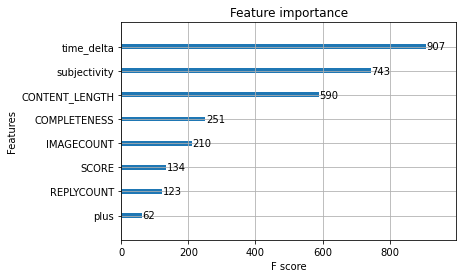

In [32]:
plot_importance(xgb_0)
pyplot.show()

In [ ]:
xgb_0.feature_names

### LogisticRegression

#### LogisticRegression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

all_x = dff[['CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity']]
all_y = dff['whether_useful']
x_train,x_test,y_train,y_test = train_test_split(all_x, all_y, train_size=0.7, random_state=30)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

lr_0 = LogisticRegression()
lr_0.fit(x_train, y_train)
y_pred = lr_0.predict(x_test)

from sklearn.metrics import accuracy_score
print ('Accuracy: %.5f' % accuracy_score(y_test, y_pred))

from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=0, average='binary'))

from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=0, average='binary', sample_weight=None))

from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=0, average='binary', sample_weight=None))

from sklearn.metrics import roc_auc_score        
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

Accuracy: 0.91792
Precision:  0.9230769230769231
Recall:  0.9910421673585318
F1 score:  0.9558529132862711
roc_auc_score:  0.6375665382247204


#### LogisticRegressionCV

**LogisticRegression和LogisticRegressionCV的主要区别是LogisticRegressionCV使用了交叉验证来选择正则化系数C。而LogisticRegression需要自己每次指定一个正则化系数。除了交叉验证，以及选择正则化系数C以外， LogisticRegression和LogisticRegressionCV的使用方法基本相同。**

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

all_x = dff[['CONTENT_LENGTH','REPLYCOUNT','IMAGECOUNT','SCORE','plus','not_plus','time_delta','COMPLETENESS','subjectivity']]
all_y = dff['whether_useful']
x_train,x_test,y_train,y_test = train_test_split(all_x, all_y, train_size=0.7, random_state=30)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

lr_0 = LogisticRegressionCV()
lr_0.fit(x_train, y_train)
y_pred = lr_0.predict(x_test)

from sklearn.metrics import accuracy_score
print ('Accuracy: %.5f' % accuracy_score(y_test, y_pred))

from sklearn.metrics import precision_score
print('Precision: ', precision_score(y_test, y_pred, labels=None, pos_label=0, average='binary'))

from sklearn.metrics import recall_score
print('Recall: ', recall_score(y_test, y_pred, labels=None, pos_label=0, average='binary', sample_weight=None))

from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, labels=None, pos_label=0, average='binary', sample_weight=None))

from sklearn.metrics import roc_auc_score        
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

Accuracy: 0.91812
Precision:  0.9232648076531651
Recall:  0.9910421673585318
F1 score:  0.9559536354056901
roc_auc_score:  0.6385135079216903
